In [ ]:
!pip install git+http://hf.co/usm3d/tools.git    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PerspectiveCameras
)
from pytorch3d.structures import Pointclouds
import webdataset as wds 
import numpy as np
from huggingface_hub import hf_hub_download
from hoho import proc
from tqdm import tqdm
import sys
sys.path.append('..')
import trimesh
import hoho
from hoho import *
from hoho.vis import line
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm
from hoho.viz3d import plot_estimate_and_gt
import itertools  
import random
import cv2 as cv2

from my_solution import predict
from helpers import *
from geom_solver import GeomSolver, one_line_solution
from hoho.color_mappings import gestalt_color_mapping, ade20k_color_mapping

import huggingface_hub  
huggingface_hub.login()

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# One shard of the dataset
dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
            filename='data/val/inputs/hoho_v3_025-of-032.tar.gz',
            repo_type="dataset"))
dataset_targets = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
            filename='data/val/targets/hoho_v3_025-of-032.tar.gz',
            repo_type="dataset"))

dataset = dataset.decode()
dataset = dataset.map(proc)

dataset_targets = dataset_targets.decode()
dataset_targets = dataset_targets.map(proc)
sc0 = []
sc = []
for ki, (entry, entry_gt) in tqdm(enumerate(zip(dataset, dataset_targets))):
    solver = GeomSolver(return_fully_connected=False, return_edges=False)
    vertices, edges = solver.solve(entry)
    
    # nverts = entry_gt['wf_vertices'].shape[0]
    # nverts = vertices.shape[0]
    nverts = 23
    vertices0, edges0 = one_line_solution(nverts)

    scores0 = (compute_WED(vertices0,
            edges0,
            np.array(entry_gt['wf_vertices']),
            np.array(entry_gt['wf_edges'])))

    scores = (compute_WED(vertices,
                edges,
                np.array(entry_gt['wf_vertices']),
                np.array(entry_gt['wf_edges'])))
    # print(scores0, scores)
    sc0.append(scores0)
    sc.append(scores)

print("Averages")
print(np.mean(sc0), np.mean(sc))



In [69]:
dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
            filename='data/train/hoho_v3_000-of-032.tar.gz',
            repo_type="dataset"))
dataset = dataset.decode()
dataset = dataset.map(proc)
for ki, entry in enumerate(dataset):
    if ki >= 33:
        break
solver = GeomSolver(return_fully_connected=False, return_edges=True)
vertices, edges = solver.solve(entry)

In [70]:
print(my_compute_WED(vertices,
            edges,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges'])))

[0 1 2 3 4 5 6 7 8] [ 5  6  0  4  3 15  8  7 16]
1808.711001352663 0.0 8260.721159421442 0.0 6681.711893031297
1.6631176981951867


In [71]:
print(entry['wf_vertices'].shape, vertices.shape[0])
# vertices, edges = one_line_solution(17)
print(my_compute_WED(vertices,
            edges,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']), preregister=False))

plot_estimate_and_gt(   vertices, 
                        edges,         
                        np.array(entry['wf_vertices']),
                        np.array(entry['wf_edges']))


(18, 3) 9
[0 1 2 3 4 5 6 7 8] [ 5  6  0  4  3 14  8  7 17]
393.0263037233088 0.0 8260.721159421442 0.0 6681.711893031297
1.5225631027521005


# Visualizing inputs

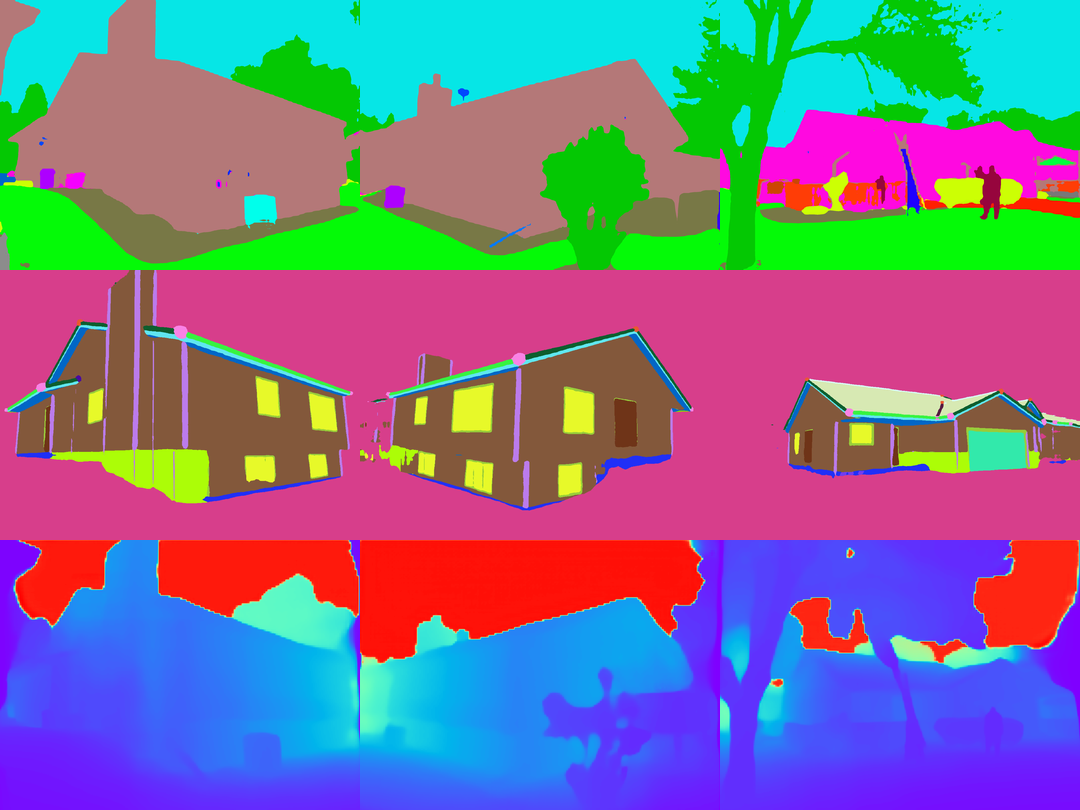

In [19]:
human_entry = convert_entry_to_human_readable(entry)

# for ki in range(len(human_entry['gestalt'])):
#     plt.figure()
#     plt.imshow(human_entry['gestalt'][ki])
#     plt.title('Gestalt segmentation')

# plt.figure()
# depth = np.array(human_entry['depthcm'][0])/100.
# depth[depth>20] = 0
# depth = depth/depth.max()
# plt.title('Monodepth')
# plt.imshow(depth, cmap='rainbow')

vis.visualize_order_images(human_entry)

In [25]:
col_cams = [hoho.Rt_to_eye_target(human_entry['ade20k'][0], to_K(*human_entry['cameras'][1].params), quaternion_to_rotation_matrix(colmap_img.qvec), colmap_img.tvec) for colmap_img in human_entry['images'].values()]
eye, target, up, fov = col_cams[0]

cameras, images, points3D = human_entry['cameras'], human_entry['images'], human_entry['points3d']
colmap_cameras_tf = list(human_entry['images'].keys())

xyz = np.stack([p.xyz for p in points3D.values()])
color = np.stack([p.rgb for p in points3D.values()])
pcd = trimesh.Scene([trimesh.PointCloud(vertices=xyz, colors=color)])

V, E = human_entry['wf_vertices'], human_entry['wf_edges']
wf = vis.show_wf(human_entry)

ax = [line((0,0,0), 1200*b, c=255*b, radius=15) for b in np.eye(3)]

u = trimesh.Trimesh(vertices=human_entry['mesh_vertices'] , faces=human_entry['mesh_faces'][:, 1:])

cams = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6) for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[human_entry[k] for k in 'ade20k K R t'.split()]))])
cams_colmap = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6, c=(0,0,255)) for eye, target, up, fov in col_cams])

gestalt_camcet = np.stack([eye for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[human_entry[k] for k in 'ade20k K R t'.split()]))])
col_camcet = np.stack([eye for eye, target, up, fov in col_cams])
gestalt_to_colmap_cams = [colmap_cameras_tf[np.argmin(((gcam - col_camcet)**2).sum(1)**0.5)] for gcam in gestalt_camcet]
broken_cams = np.array([np.min(((gcam - col_camcet)**2).sum(1)**0.5) for gcam in gestalt_camcet]) > 300

trimesh.Scene([
        # u,
        # ax,
        cams,
        cams_colmap,
        pcd,
        *wf
    ]).show()

Some additional visualizations

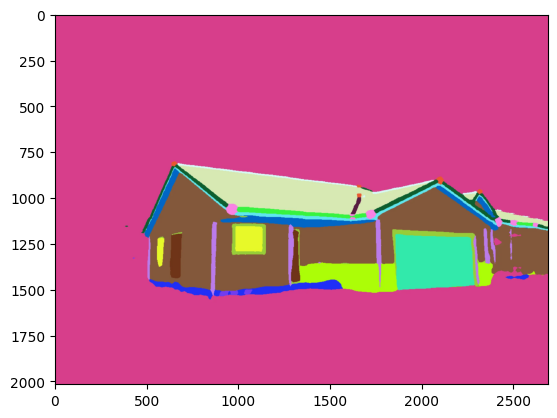

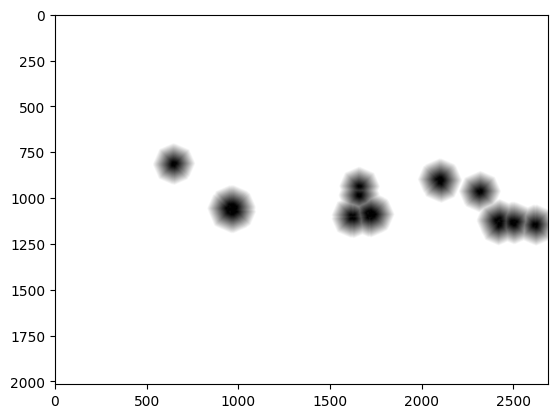

In [31]:
ki = 2
clr_th = 2.5

gest = np.array(human_entry['gestalt'][ki])
apex_color = np.array(gestalt_color_mapping['apex'])
apex_mask = cv2.inRange(gest,  apex_color-clr_th, apex_color+clr_th)
eave_end_color = np.array(gestalt_color_mapping['eave_end_point'])
eave_end_mask = cv2.inRange(gest,  eave_end_color-clr_th, eave_end_color+clr_th)
vert_mask = apex_mask + eave_end_mask
# vert_mask = cv2.dilate(vert_mask, np.ones((5,5)), iterations = 7)
vert_mask = (vert_mask > 0).astype(np.uint8)


dist = cv2.distanceTransform(1-vert_mask, cv2.DIST_L2, 3)
dist[dist > 100] = 100
ndist = np.zeros_like(dist)
ndist = cv2.normalize(dist, ndist, 0, 1.0, cv2.NORM_MINMAX)

plt.imshow(np.array(human_entry['gestalt'][ki]))
plt.figure()
plt.imshow(ndist, cmap='gray')

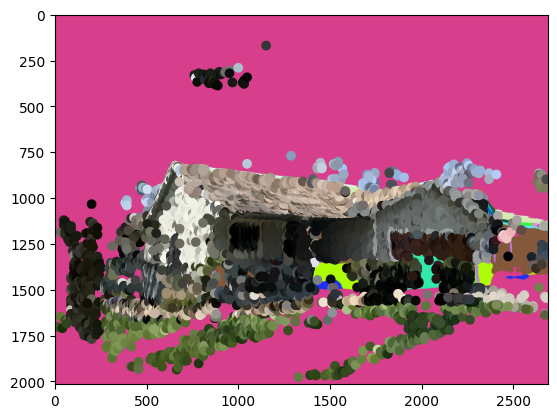

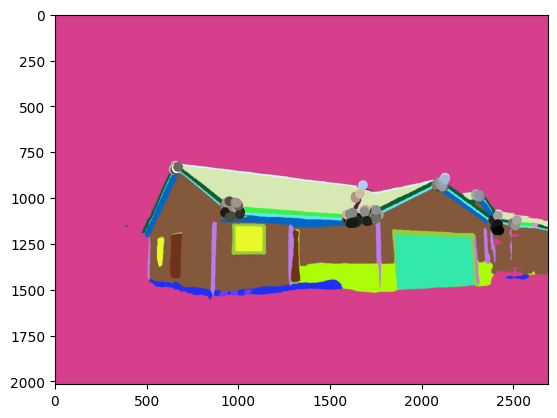

In [32]:
device = 'cuda:0'
height = cameras[1].height
width = cameras[1].width
N = len(gestalt_to_colmap_cams)
cki = gestalt_to_colmap_cams[ki]

# K, R, T = human_entry['K'], human_entry['R'], human_entry['t']
K = to_K(*human_entry['cameras'][1].params)[None].repeat(N, 0)
R = np.stack([quaternion_to_rotation_matrix(human_entry['images'][gestalt_to_colmap_cams[ind]].qvec) for ind in range(N)])
T = np.stack([human_entry['images'][gestalt_to_colmap_cams[ind]].tvec for ind in range(N)])

R = np.linalg.inv(R)
image_size=torch.Tensor([height, width]).repeat(N, 1)

verts = torch.from_numpy(xyz.astype(np.float32)).to(device)
clrs = torch.from_numpy(color.astype(np.float32)).to(device)
point_cloud = Pointclouds(points=[verts], features=[clrs])

pyt_cameras = PerspectiveCameras(device=device, R=R, T=T, in_ndc=False, focal_length=K[:, 0, :1], principal_point=K[:, :2, 2], image_size=image_size)
raster_settings = PointsRasterizationSettings(
    image_size=[height, width], 
    radius = 0.02,
    points_per_pixel = 10
)

renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=pyt_cameras[ki], raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)
images = renderer(point_cloud)

in_this_image = np.array([cki in p.image_ids for p in points3D.values()])
uv = torch.round(pyt_cameras[ki].transform_points(verts)[:, :2]).cpu().numpy().astype(int)
uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height) * in_this_image
uv = uv[uv_inl]
uv_clrs = clrs[uv_inl].cpu().numpy() / 255

vert_inl = dist[uv[:,1], uv[:,0]] < 20
vert_uv = uv[vert_inl]
vert_uv_clrs = uv_clrs[vert_inl]

plt.figure()
plt.imshow(gest)
# plt.imshow(images[0].cpu().numpy()[::-1,::-1]/255)
plt.scatter(uv[:, 0], uv[:, 1], c=uv_clrs)

plt.figure()
plt.imshow(gest)
plt.scatter(vert_uv[:, 0], vert_uv[:, 1], c=vert_uv_clrs)
# plt.scatter(uv[:, 0], uv[:, 1], c=uv_clrs)
